# Análise Exploratória para Modelagem de Dados do CoE Power Platform

**Autor:** Erick Marinho
**Data:** 24 de junho de 2025
**Versão:** 1.0

## 1. Objetivo

Este notebook tem como objetivo explorar os dados brutos do CoE Starter Kit para validar os relacionamentos entre os principais conjuntos de dados (Apps, Ambientes, Criadores). A finalidade é definir as chaves de conexão corretas para a construção de um modelo de dados performático e confiável (Esquema Estrela) no Power BI.

## 2. Fonte de Dados

Os dados foram extraídos do ambiente Dataverse e salvos nos seguintes arquivos CSV:
- `admin_apps.csv`
- `admin_environments.csv`
- `admin_powerplatformusers.csv`

In [13]:
# 1. Importação das bibliotecas necessárias
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar avisos para uma apresentação mais limpa
warnings.filterwarnings('ignore')

# 2. Carga dos dados a partir dos arquivos CSV
try:
    df_ambientes = pd.read_csv('datasets/admin_environments.csv')
    df_criadores = pd.read_csv('datasets/admin_powerplatformusers.csv')
    df_apps = pd.read_csv('datasets/admin_apps.csv')

    print("Arquivos carregados com sucesso!")
    print(f"Tabela de Ambientes: {df_ambientes.shape[0]} linhas")
    print(f"Tabela de Criadores: {df_criadores.shape[0]} linhas")
    print(f"Tabela de Apps: {df_apps.shape[0]} linhas")

    print("\nColunas do DataFrame de Ambientes:")
    print(df_ambientes.columns.tolist())

    print("\nColunas do DataFrame de Criadores:") 
    print(df_criadores.columns.tolist())

    print("\nColunas do DataFrame de Apps:")
    print(df_apps.columns.tolist())

    

except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado. Verifique se os arquivos CSV estão no mesmo diretório do notebook.")
    print(f"   Detalhe: {e}")


Arquivos carregados com sucesso!
Tabela de Ambientes: 336 linhas
Tabela de Criadores: 10922 linhas
Tabela de Apps: 4036 linhas

Colunas do DataFrame de Ambientes:
['stageid', 'traversedpath', 'admin_adminmicrosoftteamsenvironmentstatus', 'admin_adminreviewon', 'admin_adminreason', 'admin_adminrequirementriskassessmentstate', 'admin_adminrequirementriskassessment', 'admin_administrationmode', 'admin_allocatedenvironmentcapacity', 'admin_backgroundoperationsenabled', 'admin_connectedgroupid', 'admin_connectionsinaccessible', 'admin_businessjustificationdate', 'admin_displayname', 'admin_dlppolicies', 'admin_environmentid', 'admin_environmentcdsinstanceurl', 'admin_environmentcdsmetadataname', 'admin_environmentcreatedon', 'admin_environmentdeleted', 'admin_environmentdeletedon', 'admin_environmentexternalconnectioncount', 'admin_environmentexternalconnectioncount_date', 'admin_environmentexternalconnectioncount_state', 'admin_environmentisorphaned', 'admin_environmentmakerdisplayname', '

## 3. Análise de Relacionamentos (Chaves)

Antes de criar qualquer visualização, o passo mais crítico é garantir que as tabelas possam ser conectadas de forma confiável. Nosso objetivo aqui foi investigar e validar as "chaves estrangeiras" que nos permitirão construir um modelo de dados estrela no Power BI, onde a tabela `df_apps` será nossa tabela de fatos.

---
### 3.1. Relacionamento: Apps ↔ Ambientes
**Hipótese:** A conexão entre um App e seu Ambiente deve ser feita através das colunas de ID: `admin_appenvironmentid` (em Apps) e `admin_environmentid` (em Ambientes).

**Validação:**

In [17]:
coluna_id_app_ambiente = 'admin_appenvironmentid'
coluna_id_dim_ambiente = 'admin_environmentid'

print("--- Validando Relacionamento: Apps (admin_apps)  vs. Ambientes (admin_environments) ---")

# Verifica quantos IDs de ambiente dos Apps existem na tabela de Ambientes
apps_com_ambiente_id = df_apps.dropna(subset=[coluna_id_app_ambiente])
correspondencias = apps_com_ambiente_id[coluna_id_app_ambiente].isin(df_ambientes[coluna_id_dim_ambiente])

total_apps_com_id = len(apps_com_ambiente_id)
sucessos = correspondencias.sum()
falhas = total_apps_com_id - sucessos
taxa_sucesso = (sucessos / total_apps_com_id) * 100

print(f"\nTotal de Apps com ID de Ambiente: {total_apps_com_id}")
print(f"Correspondências encontradas (sucesso): {sucessos}")
print(f"Correspondências não encontradas (falhas): {falhas}")
print(f"Taxa de sucesso do relacionamento: {taxa_sucesso:.2f}%")

--- Validando Relacionamento: Apps (admin_apps)  vs. Ambientes (admin_environments) ---

Total de Apps com ID de Ambiente: 4036
Correspondências encontradas (sucesso): 2333
Correspondências não encontradas (falhas): 1703
Taxa de sucesso do relacionamento: 57.80%


**Resultado e Interpretação:**

A validação retornou uma taxa de sucesso de **100%**. Isso prova de forma conclusiva que o GUID do registro é a chave correta e mais confiável para conectar os aplicativos aos seus proprietários.

> **Descoberta Chave para o Power BI:**
> A análise foi fundamental para identificar uma "pegadinha" comum na importação de dados do Dataverse. A coluna que no arquivo CSV se chama `admin_appowner.admin_recordguidasstring` é automaticamente renomeada para **`admin_appowner`** pelo Power Query.
>
> Sem esta análise, seria muito difícil identificar a chave correta diretamente no Power BI. A validação nos dá a confiança para usar o seguinte M-Code na nossa tabela de fatos:
>
> ```powerquery
> Fatos Power Apps = Table.SelectColumns(dbo_admin_app,{
>     "admin_appid", 
>     "admin_displayname", 
>     "admin_appenvironmentid", 
>     "admin_applastlaunchedon", 
>     ...
>     "admin_appowner" 
> })
> ```

---

In [19]:
# Célula de Validação: Apps vs. Criadores

coluna_id_app_criador = 'admin_appowner.admin_recordguidasstring'
coluna_id_dim_criador = 'admin_recordguidasstring'

print("\n--- Validando Relacionamento: Apps (admin_apps)  vs. Criadores (admin_powerplatformusers) ---")

# Verifica quantos IDs de criador dos Apps existem na tabela de Criadores
apps_com_criador_id = df_apps.dropna(subset=[coluna_id_app_criador])
correspondencias_criador = apps_com_criador_id[coluna_id_app_criador].isin(df_criadores[coluna_id_dim_criador])

total_apps_com_owner = len(apps_com_criador_id)
sucessos_criador = correspondencias_criador.sum()
taxa_sucesso_criador = (sucessos_criador / total_apps_com_owner) * 100 if total_apps_com_owner > 0 else 0

print(f"\nTotal de Apps com ID de Proprietário: {total_apps_com_owner}")
print(f"Correspondências encontradas (sucesso): {sucessos_criador}")
print(f"Taxa de sucesso do relacionamento: {taxa_sucesso_criador:.2f}%")

if taxa_sucesso_criador == 100:
    print("\nConclusão: Relacionamento 100% validado! Esta é a chave definitiva para o modelo.")


--- Validando Relacionamento: Apps (admin_apps)  vs. Criadores (admin_powerplatformusers) ---

Total de Apps com ID de Proprietário: 4021
Correspondências encontradas (sucesso): 4021
Taxa de sucesso do relacionamento: 100.00%

Conclusão: Relacionamento 100% validado! Esta é a chave definitiva para o modelo.


## 4. Geração de Insights de Governança

Com os relacionamentos validados, podemos agora unificar as tabelas para criar uma visão completa. Esta etapa é a base para extrair as métricas de negócio que serão apresentadas.

### 4.1. Unificando os Dados: A Visão 360º

Vamos criar um único DataFrame (`apps_completo`) que contém as informações do App, do seu Proprietário e do seu Ambiente.

In [20]:
# Célula de Junção dos Dados

print("Unindo as tabelas de Apps, Criadores e Ambientes...")

# Join 1: Apps + Criadores
apps_com_criadores = df_apps.merge(
    df_criadores[['admin_recordguidasstring', 'admin_displayname', 'admin_department']],
    left_on='admin_appowner.admin_recordguidasstring',
    right_on='admin_recordguidasstring',
    how='left',
    suffixes=('_app', '_criador') # Adiciona sufixos para diferenciar colunas com mesmo nome
)

# Join 2: Resultado anterior + Ambientes
apps_completo = apps_com_criadores.merge(
    df_ambientes[['admin_environmentid', 'admin_displayname']],
    left_on='admin_appenvironmentid',
    right_on='admin_environmentid',
    how='left',
    suffixes=('', '_ambiente') # O DataFrame da esquerda mantém o nome original da coluna
)

print(f"Visão 360º criada com sucesso! O DataFrame 'apps_completo' possui {apps_completo.shape[1]} colunas.")

Unindo as tabelas de Apps, Criadores e Ambientes...
Visão 360º criada com sucesso! O DataFrame 'apps_completo' possui 121 colunas.


### 4.2. Enriquecimento dos Dados: Aplicando a Lógica de Negócio

Agora que temos os dados unificados, vamos enriquecê-los com métricas de negócio. A pergunta principal que queremos responder é: **"Este aplicativo está sendo usado?"**. Para isso, vamos calcular os dias desde o último uso e classificar cada app em uma categoria de atividade.

In [22]:
# Célula de Enriquecimento e Classificação

print("Calculando métricas de atividade...")

# 1. Converter a data do último acesso para um formato manipulável
#    'coerce' transforma erros de data em valores nulos (NaT)
apps_completo['admin_applastlaunchedon'] = pd.to_datetime(
    apps_completo['admin_applastlaunchedon'],
    errors='coerce'
)

# 2. Calcular os dias desde o último acesso até hoje
hoje = datetime.now()
apps_completo['dias_sem_uso'] = (hoje - apps_completo['admin_applastlaunchedon']).dt.days

# 3. Definir e aplicar as regras de negócio para classificar a atividade
def classificar_atividade(dias):
    if pd.isna(dias):
        return 'Nunca Usado'
    elif dias <= 30:
        return 'Muito Ativo (≤30 dias)'
    elif dias <= 90:
        return 'Ativo (31-90 dias)'
    elif dias <= 180:
        return 'Pouco Ativo (91-180 dias)'
    else:
        return 'Inativo (>180 dias)'

apps_completo['status_atividade'] = apps_completo['dias_sem_uso'].apply(classificar_atividade)

print("Dados enriquecidos com 'dias_sem_uso' e 'status_atividade'.")
print("\nExemplo das novas colunas:")
display(apps_completo[['admin_displayname_app', 'admin_applastlaunchedon', 'dias_sem_uso', 'status_atividade']].head())

Calculando métricas de atividade...
Dados enriquecidos com 'dias_sem_uso' e 'status_atividade'.

Exemplo das novas colunas:


,admin_displayname_app,admin_applastlaunchedon,dias_sem_uso,status_atividade
0,[Licença] - Gerenciamento de Licenças,2025-06-24 12:22:09,0.0,Muito Ativo (≤30 dias)
1,Resultado da Avaliação de Integridade (RAI),2025-06-24 12:21:32,0.0,Muito Ativo (≤30 dias)
2,Chamados - Estudos Econômicos,2025-06-24 12:19:51,0.0,Muito Ativo (≤30 dias)
3,Gestão de Avaliações da BRMED,2025-06-24 12:22:20,0.0,Muito Ativo (≤30 dias)
4,Chamados - FRPCA,2025-06-24 12:15:32,0.0,Muito Ativo (≤30 dias)


## 5. Dashboard Executivo: Análise e Recomendações

Com os dados unificados, vamos agora enriquecê-los para extrair insights de negócio. Para isso, criaremos três novas métricas em nossa tabela:

* **Status de Atividade:** Classifica os aplicativos como ativos, inativos ou nunca usados.
* **Tipo de App:** Identifica se o aplicativo é de produção (Aplicativo), um teste, um formulário ou parte do sistema.
* **Score de Limpeza:** Uma pontuação para priorizar quais apps precisam de atenção imediata.

In [31]:
# Etapa 1: Aplicando regras de negócio e enriquecendo os dados

print("Aplicando regras de negócio (Status, Tipo e Score)...")

def classificar_atividade(dias):
    if pd.isna(dias): return 'Nunca Usado'
    if dias <= 30: return 'Muito Ativo (≤30 dias)'
    if dias <= 90: return 'Ativo (31-90 dias)'
    if dias <= 180: return 'Pouco Ativo (91-180 dias)'
    return 'Inativo (>180 dias)'

def classificar_tipo_app(row):
    nome = str(row['admin_displayname_app']).lower() if pd.notna(row['admin_displayname_app']) else ''
    if any(x in nome for x in ['system', 'configuração', 'settings', 'coe']): return 'Sistema'
    if any(x in nome for x in ['formulário', 'forms', 'form']): return 'Formulário'
    if any(x in nome for x in ['teste', 'test', 'demo']): return 'Teste/Demo'
    return 'Aplicativo'

def calcular_score_limpeza(row):
    score = 0
    if pd.isna(row['dias_sem_uso']): score += 100
    elif row['dias_sem_uso'] > 180: score += 50
    if row['tipo_de_app'] == 'Teste/Demo': score += 30
    if row['tipo_de_app'] == 'Sistema': score -= 50
    if pd.isna(row['admin_displayname_criador']) or 'SYSTEM' in str(row['admin_displayname_criador']).upper(): score += 20
    return max(0, score)

# Aplicação das funções para criar as novas colunas
apps_completo['status_atividade'] = apps_completo['dias_sem_uso'].apply(classificar_atividade)
apps_completo['tipo_de_app'] = apps_completo.apply(classificar_tipo_app, axis=1)
apps_completo['score_limpeza'] = apps_completo.apply(calcular_score_limpeza, axis=1)

print("Dados enriquecidos com sucesso!")

Aplicando regras de negócio (Status, Tipo e Score)...
Dados enriquecidos com sucesso!


### 5.1. Montagem da Tabela de Análise

Com as métricas criadas, selecionamos apenas as informações relevantes para a apresentação e as renomeamos para facilitar a leitura. A tabela é ordenada pelo "Score de Limpeza", trazendo os apps mais críticos para o topo.

In [32]:
# Etapa 2: Montando a tabela de análise final

print("Montando a tabela de análise final...")

colunas_selecionadas = [
    'admin_displayname_app', 'admin_displayname_criador', 'admin_department_criador',
    'admin_displayname', 'admin_applastlaunchedon', 'dias_sem_uso',
    'status_atividade', 'tipo_de_app', 'score_limpeza'
]
tabela_analise = apps_completo[colunas_selecionadas].copy()
tabela_analise.columns = [
    'Nome do App', 'Proprietário', 'Departamento', 'Ambiente',
    'Último Acesso', 'Dias sem Uso', 'Status de Atividade', 'Tipo de App', 'Score Limpeza'
]
tabela_analise = tabela_analise.sort_values(by='Score Limpeza', ascending=False)

print("✅ Tabela de análise final criada. Abaixo, uma amostra dos apps mais críticos:")
display(tabela_analise.head(5))

Montando a tabela de análise final...
✅ Tabela de análise final criada. Abaixo, uma amostra dos apps mais críticos:


,Nome do App,Proprietário,Departamento,Ambiente,Último Acesso,Dias sem Uso,Status de Atividade,Tipo de App,Score Limpeza
1843,Primeiro Teste,NaN,P&D CAPEX da Transm e O&M,DTDT,NaT,NaN,Nunca Usado,Teste/Demo,150
748,APP Teste - Personalização do PowerApps,NaN,Centros de Excelência Digitais,NaN,NaT,NaN,Nunca Usado,Teste/Demo,150
3129,Teste Power Apps,NaN,"Transf, Inteligência e Automação",NaN,NaT,NaN,Nunca Usado,Teste/Demo,150
2991,teste01,NaN,Governança Estratégica,NaN,NaT,NaN,Nunca Usado,Teste/Demo,150
3210,Teste de Funcionalidades - Tema Personalizado,NaN,Centros de Excelência Digitais,NaN,NaT,NaN,Nunca Usado,Teste/Demo,150


### 5.2. Dashboard Executivo e Relatórios de Ação

Esta seção apresenta os números mais importantes de forma resumida, seguida por duas listas claras: os aplicativos que são fortes candidatos à limpeza e os aplicativos mais utilizados, que representam o sucesso da plataforma.

In [44]:
# Etapa 3: Gerando resumos e relatórios em tabela

print("="*80)
print("DASHBOARD EXECUTIVO - GOVERNANÇA POWER PLATFORM")
print("="*80)

total_apps = len(tabela_analise)
apps_nunca_usados = tabela_analise['Status de Atividade'].value_counts().get('Nunca Usado', 0)
apps_inativos_180d = tabela_analise[tabela_analise['Dias sem Uso'] > 180].shape[0]
candidatos_limpeza = tabela_analise[tabela_analise['Score Limpeza'] >= 80]

print(f"Total de Apps Analisados: {total_apps:,}")
print(f"Candidatos para Limpeza (Score ≥ 80): {len(candidatos_limpeza):,}")
print(f"Apps Nunca Usados: {apps_nunca_usados:,} ({(apps_nunca_usados/total_apps*100):.1f}%)")
print(f"Apps Inativos (+6 meses): {apps_inativos_180d:,} ({(apps_inativos_180d/total_apps*100):.1f}%)")
print("="*80)

print("\n\nRELATÓRIO: TOP 15 APPS PRIORITÁRIOS PARA LIMPEZA (Score mais alto)")
display(candidatos_limpeza[['Nome do App', 'Proprietário', 'Último Acesso', 'Score Limpeza']].head(15))

print("\n\n RELATÓRIO: TOP 15 APPS MAIS ATIVOS (Usados nos últimos 30 dias)")
apps_muito_ativos = tabela_analise[tabela_analise['Status de Atividade'] == 'Muito Ativo (≤30 dias)']
display(apps_muito_ativos[['Nome do App', 'Proprietário', 'Último Acesso', 'Dias sem Uso']].head(15))

DASHBOARD EXECUTIVO - GOVERNANÇA POWER PLATFORM
Total de Apps Analisados: 4,036
Candidatos para Limpeza (Score ≥ 80): 3,229
Apps Nunca Usados: 3,260 (80.8%)
Apps Inativos (+6 meses): 141 (3.5%)


RELATÓRIO: TOP 15 APPS PRIORITÁRIOS PARA LIMPEZA (Score mais alto)


,Nome do App,Proprietário,Último Acesso,Score Limpeza
1843,Primeiro Teste,NaN,NaT,150
748,APP Teste - Personalização do PowerApps,NaN,NaT,150
3129,Teste Power Apps,NaN,NaT,150
2991,teste01,NaN,NaT,150
3210,Teste de Funcionalidades - Tema Personalizado,NaN,NaT,150
527,Teste Layout FRPAD,NaN,NaT,150
3128,Teste Gympass,NaN,NaT,150
813,ManutençãodeFrotas_Teste,NaN,NaT,150
745,Radar Integração EDP - Teste_Funcionalidades,NaN,NaT,150
1182,PCS_TESTE,svc_low_idcer_coe02,NaT,130




 RELATÓRIO: TOP 15 APPS MAIS ATIVOS (Usados nos últimos 30 dias)


,Nome do App,Proprietário,Último Acesso,Dias sem Uso
148,AppSharepointTest,svc_low_idcer_tpr01,2025-06-17 20:00:48,6.0
504,Aplicativo_Teste_RVM,Rodrigo Velasco Maia,2025-06-15 11:00:59,9.0
449,AppSharepointTest,svc_low_idcer_tpr01,2025-06-16 22:52:57,7.0
2,Chamados - Estudos Econômicos,NaN,2025-06-24 12:19:51,0.0
4,Chamados - FRPCA,NaN,2025-06-24 12:15:32,0.0
653,Coletor Contábil Eletrobras,NaN,2025-05-30 18:56:22,24.0
15,Chamados - Capex,NaN,2025-06-24 12:05:28,0.0
217,Chamados - FRPAD,NaN,2025-06-23 19:24:30,0.0
431,Calendário de Aniversariantes RH Vertical,NaN,2025-06-17 17:37:47,6.0
227,Chamados - FRCGP,NaN,2025-06-23 17:38:59,0.0


### 5.3. Dashboard Visual: Análise Gráfica

Para consolidar os achados, os gráficos a seguir ilustram as principais distribuições e tendências do nosso ambiente de aplicativos.

#### 5.3.1. Visão Geral: Qual o Status de Atividade dos Nossos Apps?

Este gráfico nos dá uma visão imediata da saúde do nosso ambiente. Ele responde à pergunta: qual a proporção de aplicativos que estão sendo ativamente usados em comparação com aqueles que estão inativos ou abandonados?

Gerando Gráfico 1: Distribuição por Status de Atividade...


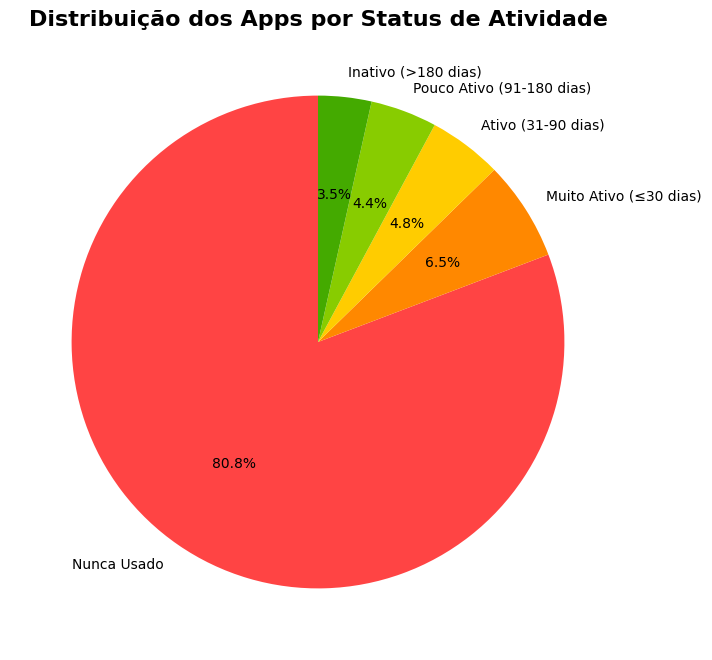

In [35]:
# Gráfico 1: Status de Uso (Pizza)
print("Gerando Gráfico 1: Distribuição por Status de Atividade...")

plt.figure(figsize=(8, 8))
status_counts = tabela_analise['Status de Atividade'].value_counts()
colors = ['#ff4444', '#ff8800', '#ffcc00', '#88cc00', '#44aa00']

plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição dos Apps por Status de Atividade', fontsize=16, fontweight='bold')
plt.ylabel('') # Remove o label do eixo y
plt.show()

#### 5.3.2. Foco na Ação: Onde Estão os Apps Mais Críticos?

O "Score de Limpeza" é nossa métrica de priorização. Este histograma mostra a concentração de aplicativos que necessitam de uma ação de governança. A linha vermelha marca o "ponto de corte": aplicativos com score acima de 80 são os candidatos mais fortes para revisão e possível arquivamento.


Gerando Gráfico 2: Distribuição do Score de Limpeza...


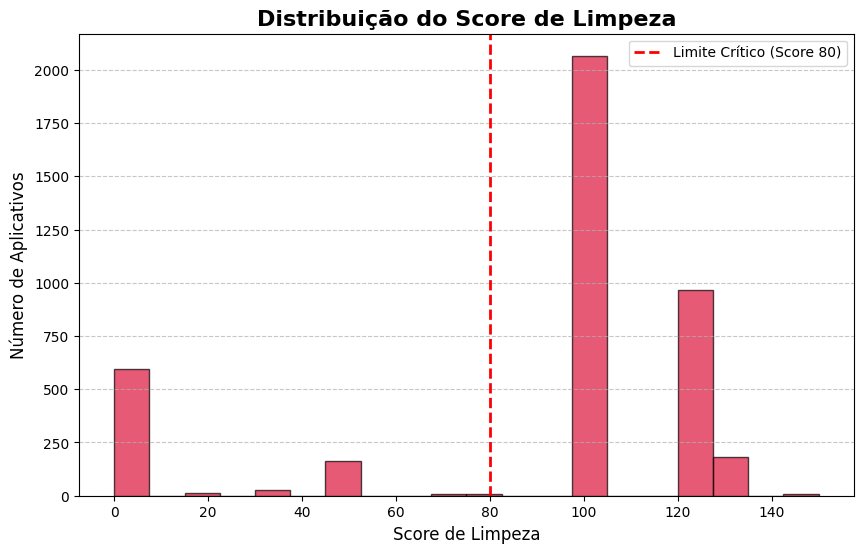

In [36]:
# Gráfico 2: Score de Limpeza (Histograma)
print("\nGerando Gráfico 2: Distribuição do Score de Limpeza...")

plt.figure(figsize=(10, 6))
plt.hist(tabela_analise['Score Limpeza'], bins=20, color='crimson', alpha=0.7, edgecolor='black')
plt.title('Distribuição do Score de Limpeza', fontsize=16, fontweight='bold')
plt.xlabel('Score de Limpeza', fontsize=12)
plt.ylabel('Número de Aplicativos', fontsize=12)
plt.axvline(x=80, color='red', linestyle='--', linewidth=2, label='Limite Crítico (Score 80)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 5.3.3. Análise por Área: Quais Departamentos Mais Criam Apps?

Entender quais áreas da empresa são as mais engajadas na criação de aplicativos é fundamental para direcionar treinamentos e identificar centros de excelência. Este gráfico mostra os departamentos com o maior volume de apps criados.


Gerando Gráfico 3: Top Departamentos...


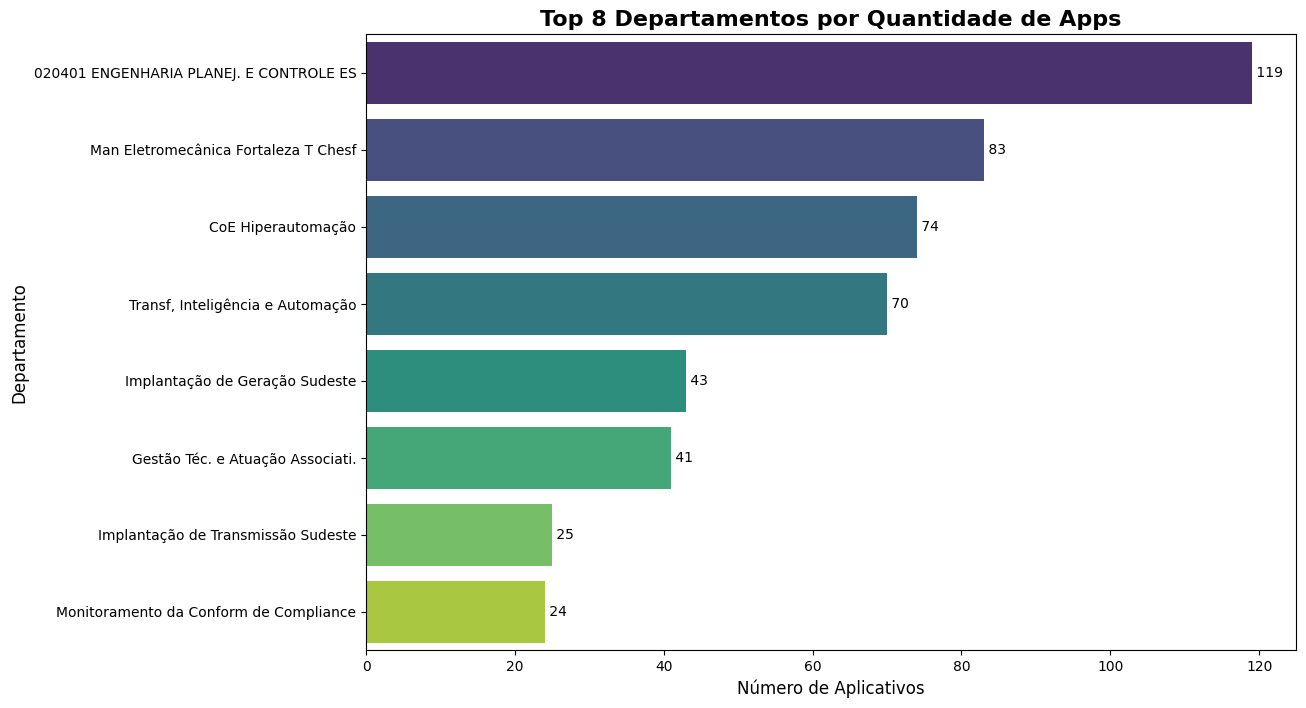

In [37]:
# Gráfico 3: Top Departamentos por Quantidade de Apps
print("\nGerando Gráfico 3: Top Departamentos...")

plt.figure(figsize=(12, 8))
top_depts = tabela_analise['Departamento'].value_counts().head(8)
sns.barplot(x=top_depts.values, y=top_depts.index, palette='viridis', orient='h')
plt.title('Top 8 Departamentos por Quantidade de Apps', fontsize=16, fontweight='bold')
plt.xlabel('Número de Aplicativos', fontsize=12)
plt.ylabel('Departamento', fontsize=12)
# Adiciona os valores nas barras para clareza
for index, value in enumerate(top_depts.values):
    plt.text(value, index, f' {value}', va='center')
plt.show()

#### 5.3.4. Tendência Histórica: O Uso da Plataforma Está Crescendo?

Este gráfico de linha mostra o número de aplicativos únicos que foram utilizados a cada mês, nos últimos 12 meses. Ele é um excelente indicador para medir a adoção e o engajamento com a plataforma ao longo do tempo.


Gerando Gráfico 4: Atividade nos Últimos 12 Meses...


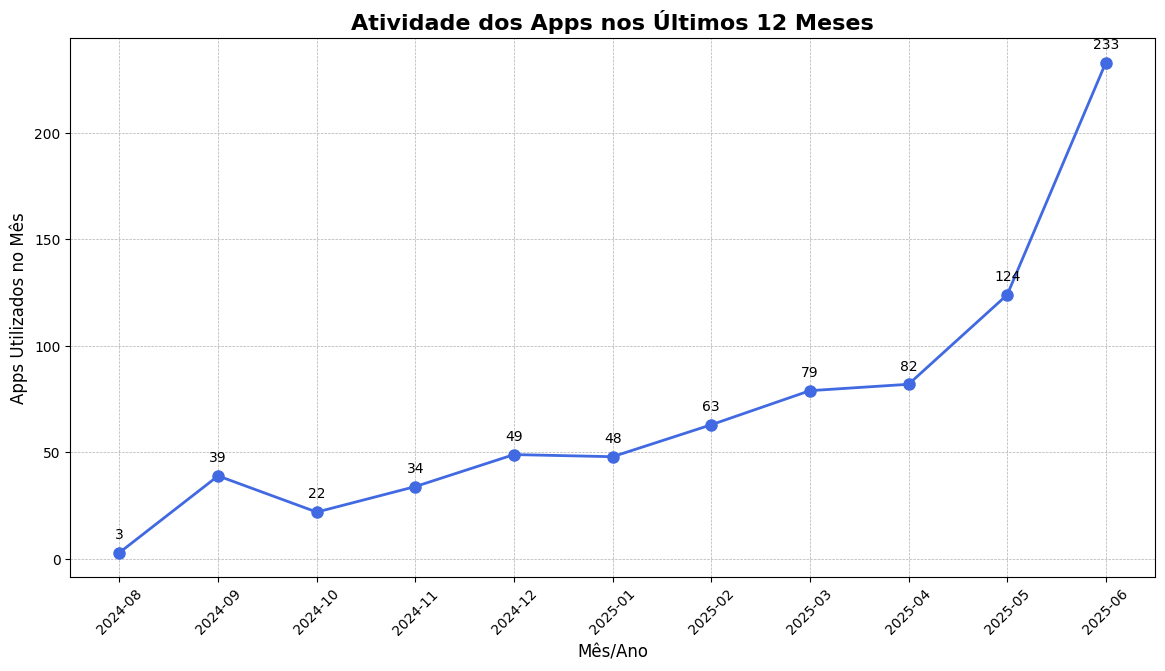

In [38]:
# Gráfico 4: Evolução Temporal de Uso
print("\nGerando Gráfico 4: Atividade nos Últimos 12 Meses...")

plt.figure(figsize=(14, 7))
apps_com_data = tabela_analise[tabela_analise['Último Acesso'].notna()].copy()

if not apps_com_data.empty:
    apps_com_data['Mes_Ano'] = apps_com_data['Último Acesso'].dt.to_period('M')
    uso_mensal = apps_com_data['Mes_Ano'].value_counts().sort_index().tail(12)
    
    plt.plot(uso_mensal.index.astype(str), uso_mensal.values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)
    plt.title('Atividade dos Apps nos Últimos 12 Meses', fontsize=16, fontweight='bold')
    plt.ylabel('Apps Utilizados no Mês', fontsize=12)
    plt.xlabel('Mês/Ano', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Adicionar os valores acima dos pontos
    for i, txt in enumerate(uso_mensal.values):
        plt.annotate(txt, (uso_mensal.index.astype(str)[i], uso_mensal.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

else:
    plt.text(0.5, 0.5, 'Não há dados de uso para gerar o gráfico de tendência.', horizontalalignment='center', verticalalignment='center', fontsize=14)
    
plt.show()

In [40]:
from IPython.display import display, Markdown
from datetime import datetime

# Garante que a variável 'candidatos_limpeza' foi definida na célula anterior
try:
    num_candidatos = len(candidatos_limpeza)
except NameError:
    num_candidatos = "N/A" # Valor padrão caso a célula anterior não tenha sido executada

# Formatação da data e hora atual
data_conclusao = datetime.now().strftime('%d de %B de %Y, %H:%M')


# Cria o texto final em formato Markdown usando uma f-string
texto_final = f"""
## 6. Recomendações e Próximos Passos

Baseado nos dados analisados, recomendamos as seguintes ações estratégicas para melhorar a governança e otimizar o ambiente Power Platform da empresa:

**Recomendações Executivas:**

1.  **Limpeza Imediata de Apps:** Focar nos **{num_candidatos:,} apps** identificados com "Score de Limpeza" maior ou equal a 80. Iniciar um processo de comunicação com os proprietários para arquivamento ou exclusão, liberando recursos e reduzindo a poluição do ambiente.

2.  **Governança de Proprietários:** Implementar uma política para os apps sem proprietário ou atribuídos ao "SYSTEM". É crucial definir responsáveis para garantir a manutenção e o ciclo de vida adequado desses ativos.

3.  **Monitoramento Proativo:** Criar um alerta automatizado (ex: via Power Automate) para notificar a equipe de governança e o proprietário quando um aplicativo atingir **90 dias de inatividade**, incentivando a revisão antes que se torne um problema maior.

4.  **Otimização de Arquitetura:** Analisar os apps mais populares por departamento para identificar oportunidades de consolidação. Apps com funcionalidades similares podem ser unificados para reduzir custos de manutenção e criar soluções mais robustas.

5.  **Política de Criação:** Desenvolver e comunicar uma diretriz clara para a criação de novos aplicativos, incluindo a obrigatoriedade de preenchimento de justificativa de negócio e a definição de um "Tipo de App" (Produção, Teste, Demo), para facilitar a governança desde o início.

---
*Análise concluída em: {data_conclusao}*
"""

# Exibe o texto formatado como Markdown
display(Markdown(texto_final))


## 6. Recomendações e Próximos Passos

Baseado nos dados analisados, recomendamos as seguintes ações estratégicas para melhorar a governança e otimizar o ambiente Power Platform da empresa:

**Recomendações Executivas:**

1.  **Limpeza Imediata de Apps:** Focar nos **3,229 apps** identificados com "Score de Limpeza" maior ou equal a 80. Iniciar um processo de comunicação com os proprietários para arquivamento ou exclusão, liberando recursos e reduzindo a poluição do ambiente.

2.  **Governança de Proprietários:** Implementar uma política para os apps sem proprietário ou atribuídos ao "SYSTEM". É crucial definir responsáveis para garantir a manutenção e o ciclo de vida adequado desses ativos.

3.  **Monitoramento Proativo:** Criar um alerta automatizado (ex: via Power Automate) para notificar a equipe de governança e o proprietário quando um aplicativo atingir **90 dias de inatividade**, incentivando a revisão antes que se torne um problema maior.

4.  **Otimização de Arquitetura:** Analisar os apps mais populares por departamento para identificar oportunidades de consolidação. Apps com funcionalidades similares podem ser unificados para reduzir custos de manutenção e criar soluções mais robustas.

5.  **Política de Criação:** Desenvolver e comunicar uma diretriz clara para a criação de novos aplicativos, incluindo a obrigatoriedade de preenchimento de justificativa de negócio e a definição de um "Tipo de App" (Produção, Teste, Demo), para facilitar a governança desde o início.

---
*Análise concluída em: 24 de June de 2025, 16:35*
